In [2]:
import os
import sys 
os.chdir("/workspaces/dev/modules")
sys.path.append("/workspaces/dev/models/R-CNN")

In [35]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
from Pills import DataLoader
from PillNet import PillNet

In [5]:
BATCH_SIZE = 1
ANNOTATION_PATH = "/workspaces/dev/datasets/pills/data/annotations.json"
IMAGE_DIR = "/workspaces/dev/datasets/pills"

In [6]:
data_loader = DataLoader(BATCH_SIZE, IMAGE_DIR, ANNOTATION_PATH)

In [7]:
model = PillNet()
model.build((None, 128, 128, 3))
model.load_weights("/workspaces/dev/models/R-CNN/checkpoints/pillnet_1.keras")


I0000 00:00:1741081884.273401   21267 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
# model = keras.models.load_model("/workspaces/dev/models/R-CNN/checkpoints/pill_net.keras", custom_objects={"PillNet": PillNet})

In [9]:
test_sequence = data_loader.get_test_sequence()

In [10]:
# test_sequence[0]

In [11]:
def visualize_mask(img, origin_mask, pred_mask):
  fig, axes = plt.subplots(2, 3, figsize=(15, 10))

  origin_mask = origin_mask.copy()
  origin_mask[origin_mask > 0] = 255
  
  pred_mask = pred_mask.copy()
  pred_mask[pred_mask > 0.5] = 255
  pred_mask[pred_mask <= 0.5] = 0

  axes[0][0].imshow(img)
  axes[0][0].set_title('Image')
  axes[0][0].axis('off')

  axes[0][1].imshow(origin_mask[:, :, 0], cmap='gray')
  axes[0][1].set_title('Mask - class 0')
  axes[0][1].axis('off')
  
  axes[0][2].imshow(origin_mask[:, :, 1], cmap='gray')
  axes[0][2].set_title('Mask - class 1')
  axes[0][2].axis('off')
  
  axes[1][0].set_visible(False)

  axes[1][1].imshow(pred_mask[:, :, 0], cmap='gray')
  axes[1][1].set_title('Pridict - class 0')
  axes[1][1].axis('off')
  
  axes[1][2].imshow(pred_mask[:, :, 1], cmap='gray')
  axes[1][2].set_title('Pridict - class 1')
  axes[1][2].axis('off')
  
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


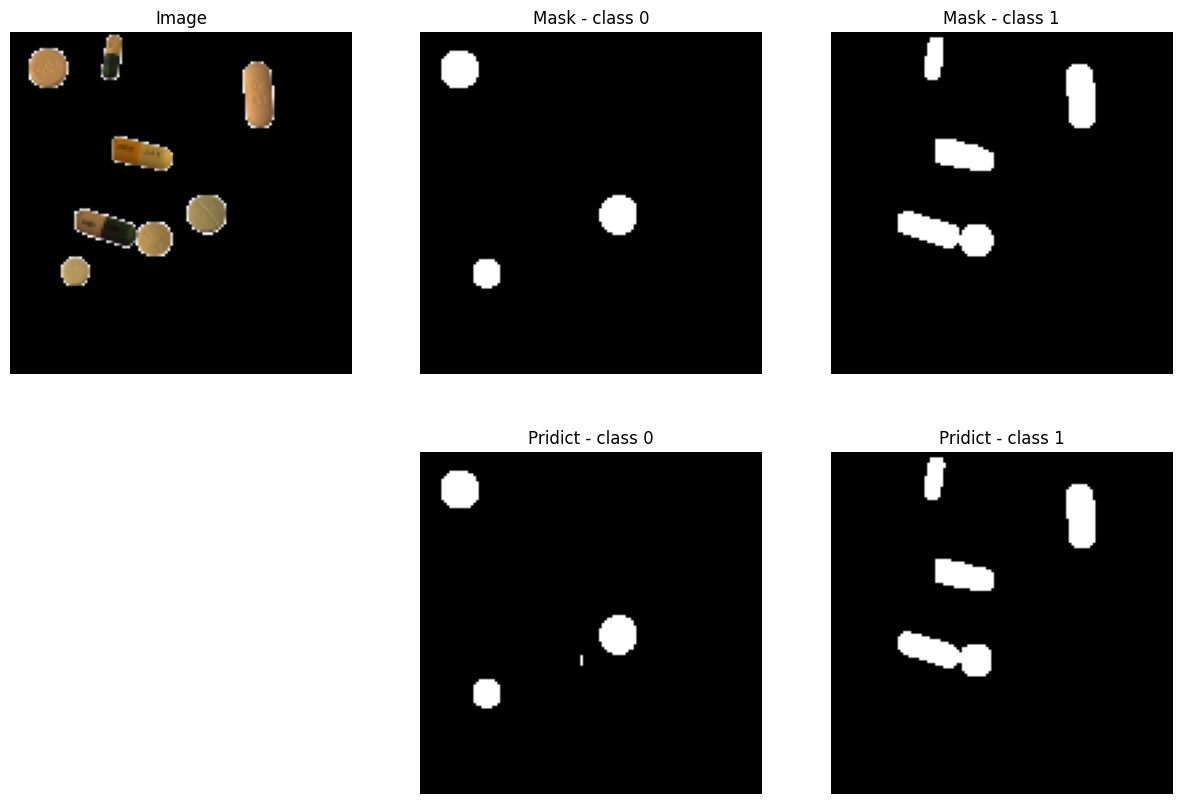

In [30]:
test_data = test_sequence[np.random.randint(len(test_sequence))]
x, y = test_data[0], test_data[1]
p_y = model.predict(x)
visualize_mask(x[0], y[0], p_y[0])

In [67]:
real_img = cv2.imread("/workspaces/dev/models/R-CNN/0.jpg")
real_img = cv2.resize(real_img, (128, 128))

img_hsv = cv2.cvtColor(real_img, cv2.COLOR_BGR2HSV)
# (OpenCV에서) HSV: H∈[0,179], S∈[0,255], V∈[0,255]

# 3) 채도(S) & 노출(밝기, V) 높이기
img_hsv = img_hsv.astype(np.float32)

s_factor = 2.0  # 채도 2배
v_factor = 1.5  # 밝기(노출) 1.5배

img_hsv[..., 1] = np.clip(img_hsv[..., 1] * s_factor, 0, 255)
img_hsv[..., 2] = np.clip(img_hsv[..., 2] * v_factor, 0, 255)

# 4) HSV -> BGR 복귀
img_hsv = img_hsv.astype(np.uint8)
high_sat_exp_img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

# 5) 필요하다면 float 형으로 [0,1] 범위로 변환
real_img = high_sat_exp_img.astype(np.float32) / 255.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


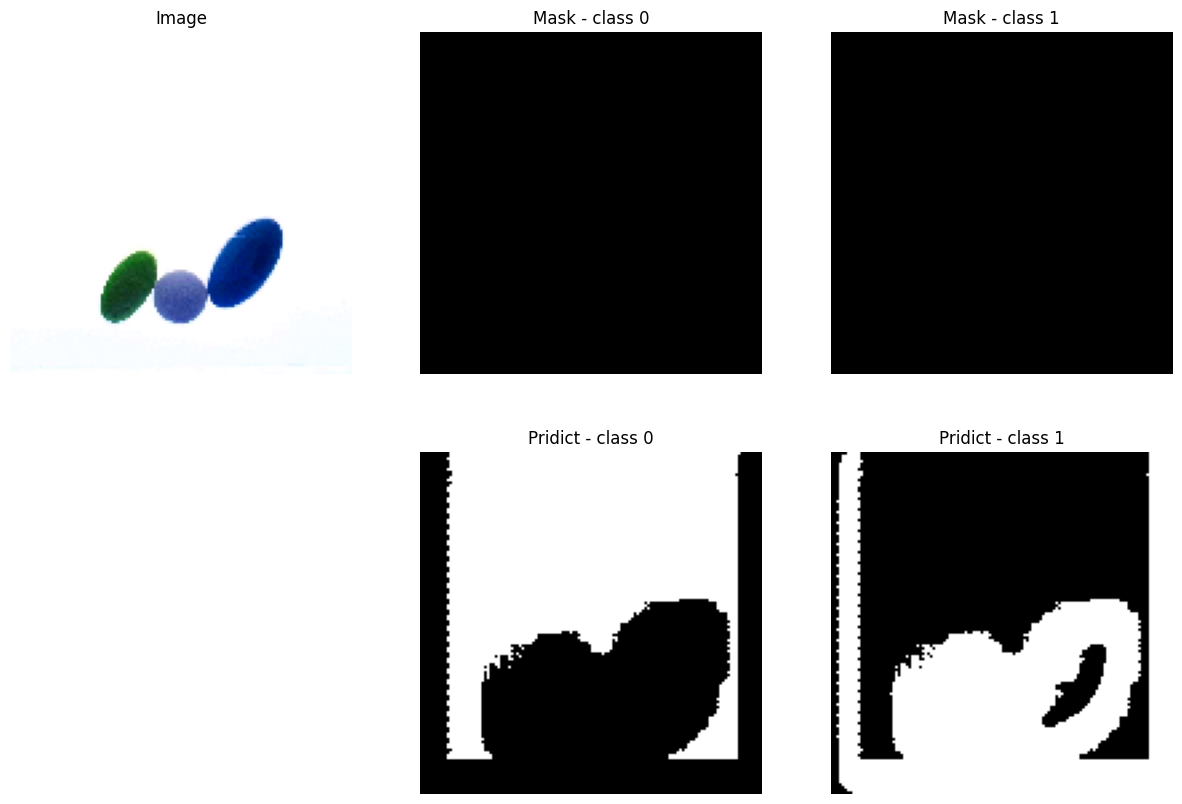

In [68]:
p_y = model.predict(np.array([real_img]))
visualize_mask(real_img, p_y[0], p_y[0])

In [31]:
def generate_background(color:tuple[int] = None, size:tuple[int] = (128, 128, 3)):
  if color is None:
    color = np.random.randint(0, 255, 3)
  color = color/255
  background = np.empty(size, dtype=np.float64)
  background[:, :] = color
  return background

In [32]:
def merge_object_with_background(object_img:np.ndarray, background:np.ndarray):
  background = background.copy()
  mask = object_img <= 0
  merged = np.where(mask, background, object_img)

  return merged

In [33]:
def show(img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


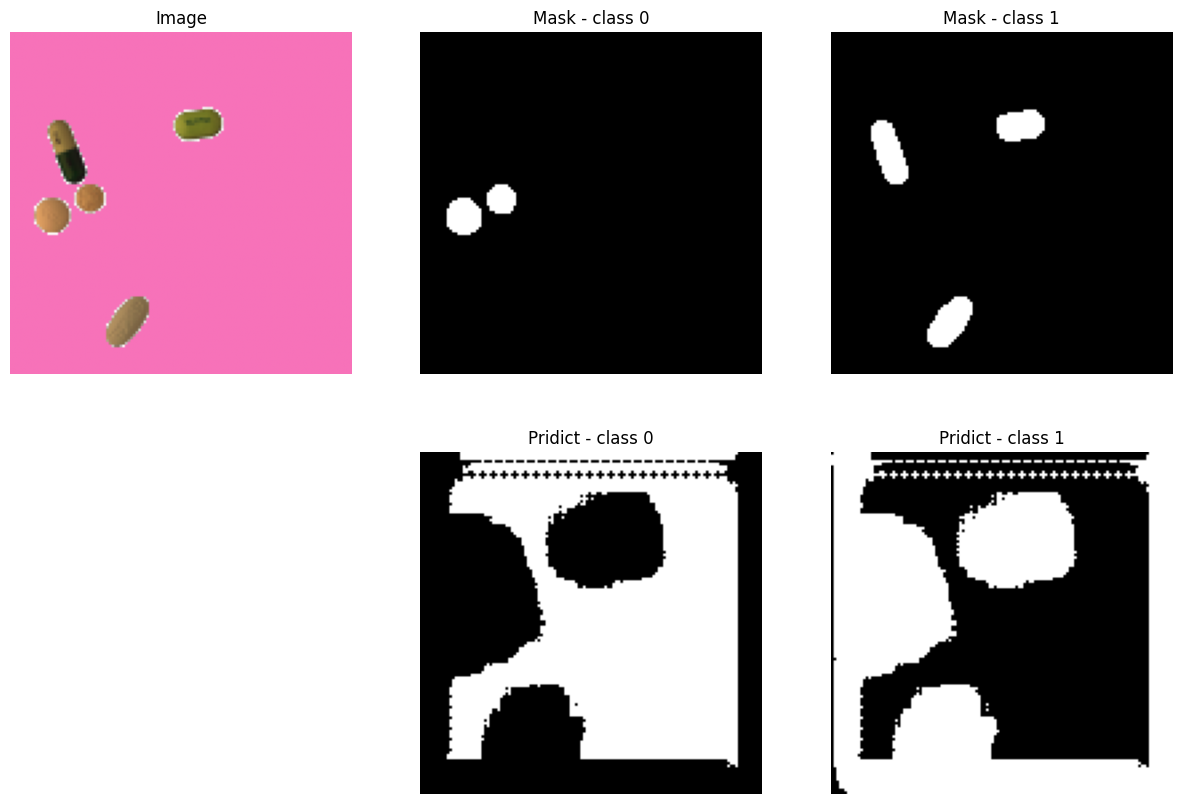

In [142]:
background_train, target = test_sequence[np.random.randint(len(test_sequence))]
background_train = background_train[0]
target = target[0]
background = generate_background()
merged = merge_object_with_background(background_train, background)
p_y = model.predict(np.array([merged]))
visualize_mask(merged, target, p_y[0])